In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau


from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.dataset.CMAPSS import (process_file_train, 
                                   process_file_test, engines, sensor_indices,
                                   operation_mode)
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.transformation.transformers import Transformer, transformation_pipeline, numericals_pipeline
from rul_pm.transformation.features.selection import (
    ByNameFeatureSelector,
    PandasVarianceThreshold,
    PandasNullProportionSelector)
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.imputers import ForwardFillImputer, PandasMeanImputer
from rul_pm.transformation.features.scalers import PandasMinMaxScaler

from rul_pm.transformation.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import get_batcher
from rul_pm.models.keras.simple import FCN


from rul_pm.transformation.transformers import Transformer, transformation_pipeline, LivesPipeline
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.imputers import ForwardFillImputer, PandasRemoveInf, PerColumnImputer
from rul_pm.transformation.utils import IdentityTransformer
from rul_pm.graphics.plots import plot_true_vs_predicted


# 1. Dataset

The Dataset comes in a space separated tabular file. The functions `process_file_train` and `process_file_test` receive the filename of the dataset file and return a `pd.DataFrame` with the pre-processed data. The `UnitNumber` column is a life identifier.

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:
    * `__getitem__(self, i)`: This method should return the i-th life 
    * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [2]:
class CMAPSSDataset(AbstractLivesDataset):
    def __init__(self, train=True, model=None):
        if model is not None:
            if model not in operation_mode:
                raise ValueError(
                    f'Invalid model: valid model are {list(operation_mode.keys())}')
        if train:
            processing_fun = process_file_train
        else:
            processing_fun = process_file_test
        self.lives = []
        for engine in engines:
            if model is not None and engine != model:
                continue
            for _, g in processing_fun(engine).groupby('UnitNumber'):
                g.drop(columns=['UnitNumber'], inplace=True)
                self.lives.append(g)

    def __getitem__(self, i):
        """

        Returns
        -------
        pd.DataFrame
            DataFrame with the data of the life i
        """
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

In [3]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
validation_dataset = CMAPSSDataset(train=False, model='FD001')

## 1.1 Number of lives in the training set

In [4]:
len(train_dataset)

100

## 1.2 Number of lives in the validation set

In [5]:
len(validation_dataset)

100

# 2. Transformers

There are two ways of defining a transformer. The first way is more similar to the scikit-learn Pipeline API, and the other one is similar tu the tensorflow functional API.
Two pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

The base class of the pipeline is the `LivesPipeline` class. This class is an extension of `sklearn.pipeline.Pipeline` and change the way the data is fitted. 
Each transformer class inherit from the `TransformerStep`. This class implements the method `partial_fit` which receives the data belonging to the whole life and update its internal state accordingly.

In [6]:
features = [train_dataset[0].columns[i] for i in sensor_indices]

## 2.1 Functional API

In [7]:
functional_pipe = ByNameFeatureSelector(features)
functional_pipe = PandasVarianceThreshold(0)(functional_pipe)
functional_pipe = PandasNullProportionSelector(0.1)(functional_pipe)
functional_pipe = IQROutlierRemover(1.5, 1)(functional_pipe)
functional_pipe = ForwardFillImputer()(functional_pipe)
functional_pipe = PandasTransformerWrapper(RobustScaler())(functional_pipe)

target_pipe = ByNameFeatureSelector(['RUL'])

In [8]:
functional_transformer = Transformer(
    transformerX=functional_pipe.build(),
    transformerY=target_pipe.build())


## 2.2 Scikit-learn API

In [9]:
transformer = Transformer(
    transformerX=transformation_pipeline(
        numericals_pipeline(
            numerical_features=[
                'T24', 'T30', 'T50',  
                'P15','P30','Nf','Nc', 'Ps30',
                'phi', 'NRf', 'NRc', 'BPR', 
                'htBleed', 'W31', 'W32'
            ],
            outlier=IQROutlierRemover(1.5, 1), 
            imputer=ForwardFillImputer(),
            scaler=PandasTransformerWrapper(RobustScaler())
        )),
    transformerY=LivesPipeline(
        steps=[
            ('select_RUL', ByNameFeatureSelector(['RUL']))
        ]
    )
    
)


## Iterators

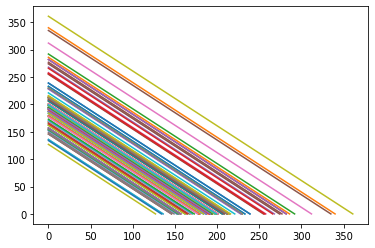

In [10]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

## Batcher

The batcher class will return the 

In [11]:
functional_transformer.fit(train_dataset)
window = 25
batch_size = 66
step = 2
train_batcher = get_batcher(train_dataset,  window, batch_size, 
                            functional_transformer, step, shuffle=False)
X, y, sw = next(train_batcher)

### How dos a sample looks like?

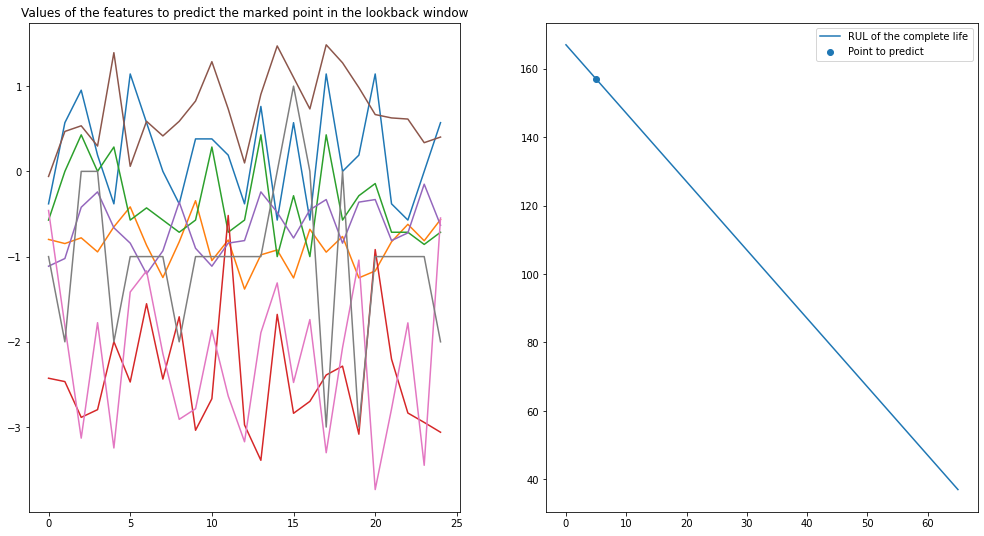

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[5, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=5, y=y[5], label='Point to predict')
ax[1].legend()

# Model

Let's create a simple model in keras with a same dense layers. The TrainableModel creates the batchers for the trainign and validation set and fit the models.

In [13]:
functional_pipe = ByNameFeatureSelector(features)
functional_pipe = PandasMinMaxScaler((-1,1))(functional_pipe)
functional_pipe = PandasMeanImputer()(functional_pipe)

target_pipe = ByNameFeatureSelector(['RUL'])
target_pipe = ForwardFillImputer()(target_pipe)

transformer = Transformer(
    transformerX=functional_pipe.build(),
    transformerY=target_pipe.build())




model = FCN([100, 50],
            dropout=0.3,
            learning_rate=0.0005,
            l2=None,
            batch_normalization=False,
            window=15,
            batch_size = 16,
            step = 1,
            transformer = transformer,
            shuffle='all',
            cache_size=100,
            patience=7)

r = model.fit(train_dataset, validation_dataset , epochs=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 210)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               21100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 26,201
Trainable params: 26,201
Non-trainable params: 0
____________________________________________________

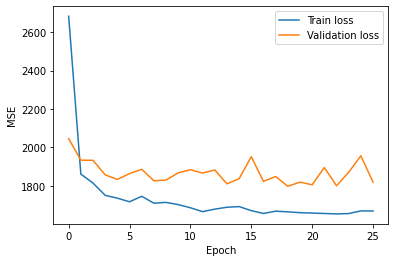

In [14]:
fig, ax = plt.subplots()
ax.plot(r.history['loss'], label='Train loss')
ax.plot(r.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

(<Figure size 1224x360 with 1 Axes>, <AxesSubplot:ylabel='Time [h]'>)

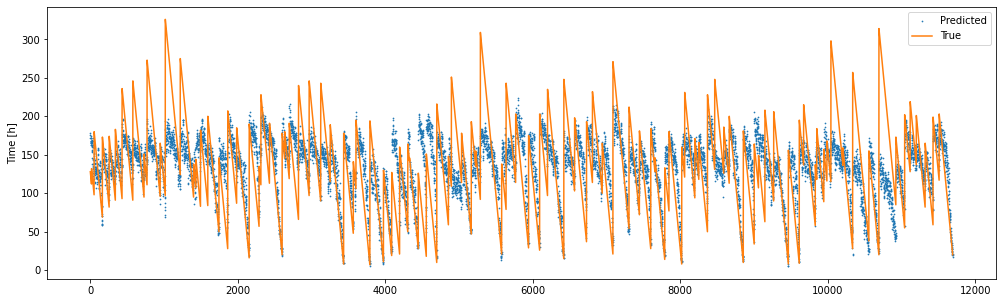

In [15]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=1)
y_true = model.true_values(validation_dataset, step=1)

plot_true_vs_predicted(y_true, y_pred, figsize=(17, 5))



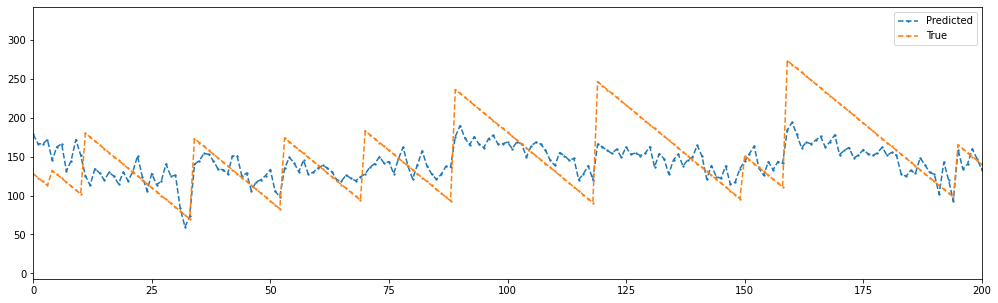

In [16]:

y_pred = model.predict(validation_dataset, step=5)
y_true = model.true_values(validation_dataset, step=5)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(np.squeeze(y_pred), 'o--', label='Predicted', markersize=1.3)
ax.plot(np.squeeze(y_true), 'o--', label='True', markersize=1.3)
ax.set_xlim(0, 200)
ax.legend()